In [1]:
from google.colab import files

# upload kaggle API key for downloading data (json format)
uploaded = files.upload()
for fn in uploaded.keys():
  print(f"File {fn} was uploaded")

# move kaggle.json into folder where API expects to find it
!mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json
File kaggle.json was uploaded


In [2]:
# https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset
!kaggle datasets download -d pranavraikokte/covid19-image-dataset

 97% 153M/158M [00:02<00:00, 59.2MB/s]
100% 158M/158M [00:02<00:00, 75.7MB/s]


In [3]:
from zipfile import ZipFile
file_path = "/content/covid19-image-dataset.zip"
with ZipFile(file_path, 'r') as zip_file:
  zip_file.extractall()
  print('Extraction Compelted')

Extraction Compelted


## Imports

In [26]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint
from  tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

In [47]:
#  input to vgg16 is 224x224 with rgb, batch_size=32
HEIGHT=224
WIDTH=224
BATCH_SIZE=32

In [48]:
# rescale pixel value [0,1]
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# for an augmentation we can use
# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    zoom_range=0.1,
#                                    rotation_range=20,
#                                    width_shift_range=0.1,
#                                    height_shift_range=0.1,
#                                    horizontal_flip = True)

One of "categorical", "binary", "sparse", "input", or None. Determines the type of label arrays that are returned:
- "categorical" will be 2D one-hot encoded labels,
- "binary" will be 1D binary labels,
- "sparse" will be 1D integer labels,
- "input" will be images identical to input images (mainly used to work with autoencoders).

If None, no labels are returned (the generator will only yield batches of image data, which is useful to use with model.predict_generator()). Please note that in case of class_mode None, the data still needs to reside in a subdirectory of directory for it to work correctly. Defaults to "categorical".

In [50]:
train_dir = "/content/Covid19-dataset/train"
test_dir = "/content/Covid19-dataset/test"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True,
    classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False,
    classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )

# shuffle=True will shuffle the images and labels within each batch
#  but the correspondence between the images and labels will be maintained.

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [51]:
total_image = np.concatenate([train_generator.labels,test_generator.labels])

In [52]:
print('Normal_cases: ',len(np.where(total_image==0)[0]))
print('Viral_Pneumonia_cases: ',len(np.where(total_image==1)[0]))
print('Covid_cases: ',len(np.where(total_image==2)[0]))

Normal_cases:  90
Viral_Pneumonia_cases:  90
Covid_cases:  137


In [53]:
train_generator.labels.shape

(251,)

In [54]:
# multiclass classification - 3 classes
np.unique(train_generator.labels)

array([0, 1, 2], dtype=int32)

## Display Images

In [55]:
images, labels = next(train_generator)

In [56]:
# per batch
labels.shape

(32,)

In [57]:
def plot_images(images_arr, labels_arr, class_indices):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        label = list(class_indices.keys())[list(class_indices.values()).index(int(lbl))]
        ax.set_title(label)
    plt.tight_layout()
    plt.show()

In [58]:
labels[:5]

array([1., 2., 1., 1., 0.], dtype=float32)

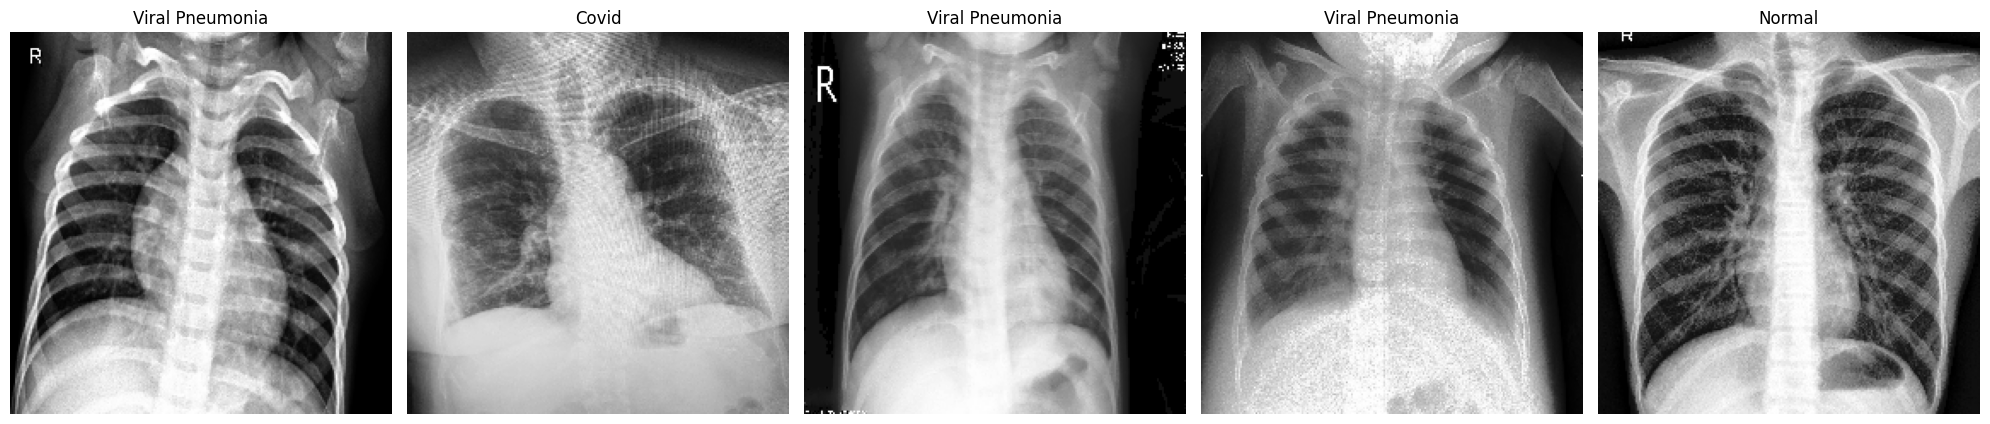

In [59]:
# Display first 5 images from the batch
plot_images(images[:5], labels[:5], train_generator.class_indices)

# Implementing VGG16 - Transfer Learning

- For binary: sigmoid in last layer
- For multiclass: softmax in last layer

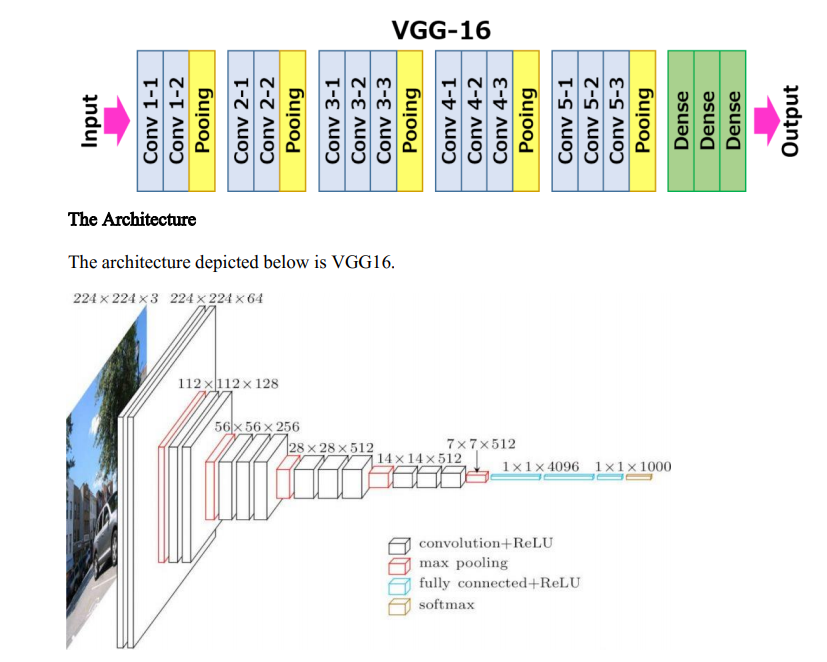

In [60]:
tf.keras.backend.clear_session()

In [61]:
# Loading VGG16 Model with Pre-trained Weights - without final (top) later as we will customize it
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(HEIGHT, WIDTH, 3))

In [62]:
# Freeze the layers of the base model
# so that ony final layer learns from new dataset
for layer in base_model.layers:
    layer.trainable = False

In [63]:
num_classes = len(train_generator.class_indices)
print('Number of classes:', num_classes)

Number of classes: 3


In [64]:
# 3. Fine-tune the Model
model = Sequential()
model.add(base_model)
# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

#
model.add(Dense(num_classes, activation='softmax'))


In [65]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                        

- SparseCategoricalCrossentropy: This loss function is used when the target labels are integers, e.g., [0, 2, 1, ...] where each integer corresponds to a class. So, if you have 3 classes, the labels would be 0, 1, or 2.
- CategoricalCrossentropy: This loss function is used when the target labels are one-hot encoded, e.g., for three classes, the labels would look like: [[1, 0, 0], [0, 0, 1], [0, 1, 0], ...]

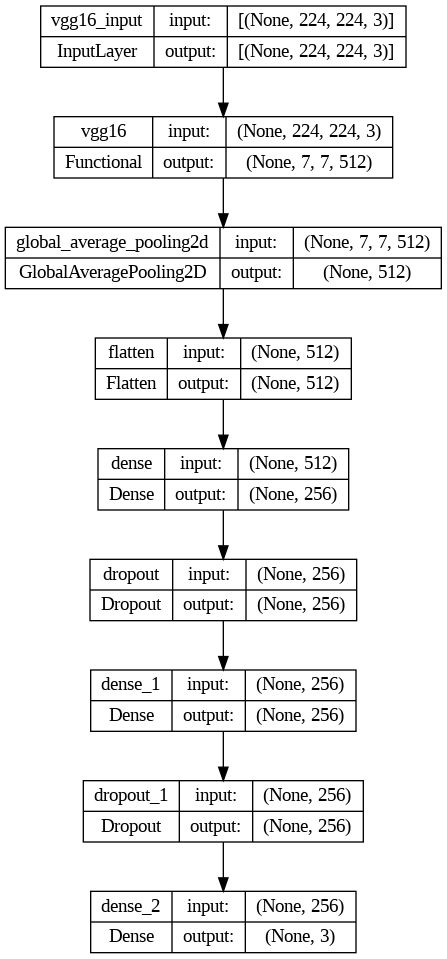

In [66]:
tf.keras.utils.plot_model(model, to_file='vgg16-image-classifier.png', show_shapes=True, show_layer_names=True)

In [67]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [68]:
# def f1_score(y_true, y_pred):
#     def recall(y_true, y_pred):
#         true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#         possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#         recall = true_positives / (possible_positives + K.epsilon())
#         return recall

#     def precision(y_true, y_pred):
#         true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#         predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#         precision = true_positives / (predicted_positives + K.epsilon())
#         return precision

#     precision_val = precision(y_true, y_pred)
#     recall_val = recall(y_true, y_pred)
#     return 2*((precision_val * recall_val) / (precision_val + recall_val + K.epsilon()))


# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss='categorical_crossentropy',
#               metrics=[f1_score])


## Adding Callbacks

In [69]:
checkpoint = ModelCheckpoint('vgg16_best_weights.h5',
                             monitor='val_accuracy',
                            #  monitor='val_f1_score',
                             verbose=1,
                             mode='max',
                             save_best_only=True)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      restore_best_weights=True,
                      patience=5)

callbacks_list = [checkpoint,early]

## Training model
Model weights will be saved to a file called `vgg16_best_weights.h5` whenever there is an improvement in validation accuracy.
After training we can load these weights back into model using `model.load_weights('vgg16_best_weights.h5')`

In [70]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[callbacks_list],
    verbose=True,
    shuffle=True)

Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 1.1199 - accuracy: 0.4422
Epoch 1: val_accuracy improved from -inf to 0.39394, saving model to vgg16_best_weights.h5
8/8 [==============================] - 16s 1s/step - loss: 1.1199 - accuracy: 0.4422 - val_loss: 1.0960 - val_accuracy: 0.3939


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 1.0893 - accuracy: 0.4741
Epoch 2: val_accuracy improved from 0.39394 to 0.75758, saving model to vgg16_best_weights.h5
8/8 [==============================] - 6s 741ms/step - loss: 1.0893 - accuracy: 0.4741 - val_loss: 0.9200 - val_accuracy: 0.7576
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 1.0057 - accuracy: 0.5060
Epoch 3: val_accuracy did not improve from 0.75758
8/8 [==============================] - 6s 733ms/step - loss: 1.0057 - accuracy: 0.5060 - val_loss: 0.8101 - val_accuracy: 0.7576
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 0.8126 - accuracy: 0.6335
Epoch 4: val_accuracy improved from 0.75758 to 0.77273, saving model to vgg16_best_weights.h5
8/8 [==============================] - 7s 850ms/step - loss: 0.8126 - accuracy: 0.6335 - val_loss: 0.6939 - val_accuracy: 0.7727
Epoch 5/50
8/8 [==============================] - ETA: 0s - loss: 0.7173 - accuracy: 0.6892
Epoch 

In [71]:
model.save('vgg16_complete_model.h5')

## Plotting the results

In [72]:
def plot_learning_curve(history, metrics):
    acc = history.history[metrics]
    val_acc = history.history[f'val_{metrics}']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(5,3))
    plt.plot(epochs, acc, label=f'training {metrics}')
    plt.plot(epochs, val_acc, label=f'validation {metrics}')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    plt.legend()

    plt.figure(figsize=(5,3))
    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

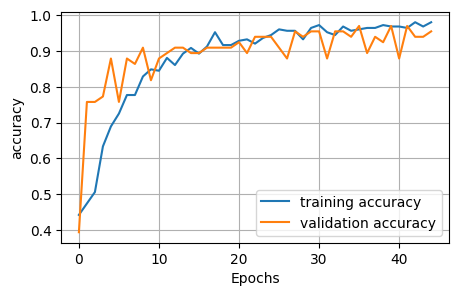

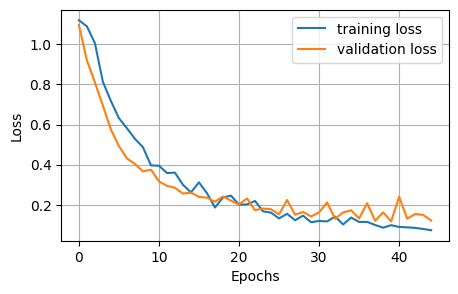

In [73]:
plot_learning_curve(history, metrics='accuracy')

## Evaluate Model

In [74]:
train_result = model.evaluate(train_generator)
test_result = model.evaluate(test_generator)

3/3 [==============================] - 1s 125ms/step - loss: 0.1175 - accuracy: 0.9697


In [75]:
print(f"Train Loss: {np.round(train_result[0], 4)}")
print(f"Test Loss: {np.round(test_result[0], 4)}")
print(f"Train Accuracy: {np.round(train_result[1], 3)}")
print(f"Test Accuracy: {np.round(test_result[1], 3)}")

Train Loss: 0.0537
Test Loss: 0.1175
Train Accuracy: 0.984
Test Accuracy: 0.97


In [76]:
y_pred_probs = model.predict(test_generator)
print(y_pred_probs.shape)

3/3 [==============================] - 1s 236ms/step
(66, 3)


In [77]:
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int32)

In [78]:
y_true.shape

(66,)

In [79]:
print('Normal_cases: ',len(np.where(y_true==0)[0]))
print('Viral_Pneumonia_cases: ',len(np.where(y_true==1)[0]))
print('Covid_cases: ',len(np.where(y_true==2)[0]))

Normal_cases:  20
Viral_Pneumonia_cases:  20
Covid_cases:  26


In [80]:
y_pred_probs = model.predict(test_generator)

3/3 [==============================] - 1s 187ms/step


In [81]:
classes_names = list(test_generator.class_indices.keys())

In [82]:
# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
# Calculate confusion matrix
confusion = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", confusion)
# Calculate perfect confusion matrix
p_confusion = confusion_matrix(y_true, y_true)
print("Perfect Confusion Matrix:\n", p_confusion)
# Calculate precision, recall, and f1-score
report = classification_report(y_true, y_pred, target_names=classes_names)
print("\nClassification Report:\n", report)

Confusion Matrix:
 [[18  2  0]
 [ 0 20  0]
 [ 0  0 26]]
Perfect Confusion Matrix:
 [[20  0  0]
 [ 0 20  0]
 [ 0  0 26]]

Classification Report:
                  precision    recall  f1-score   support

         Normal       1.00      0.90      0.95        20
Viral Pneumonia       0.91      1.00      0.95        20
          Covid       1.00      1.00      1.00        26

       accuracy                           0.97        66
      macro avg       0.97      0.97      0.97        66
   weighted avg       0.97      0.97      0.97        66



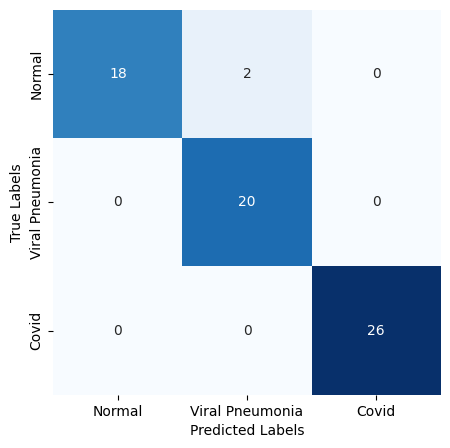

In [83]:
plt.figure(figsize=(5, 5))
hmap = sns.heatmap(confusion, annot=True, vmin=0,
                 fmt='g', cmap='Blues', cbar=False,
                 xticklabels=classes_names,
                 yticklabels=classes_names)

hmap.set(xlabel='Predicted Labels')
hmap.set(ylabel='True Labels')
plt.show()

In [84]:
#Extract wrong classification index
wrong_pred = np.where(y_pred!=y_true)[0]
print(f'Total of {len(wrong_pred)} missclassified images')
print('Missclassified images index: ',wrong_pred)

Total of 2 missclassified images
Missclassified images index:  [ 7 12]


In [85]:
images, true_labels = next(test_generator)

In [86]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int32)

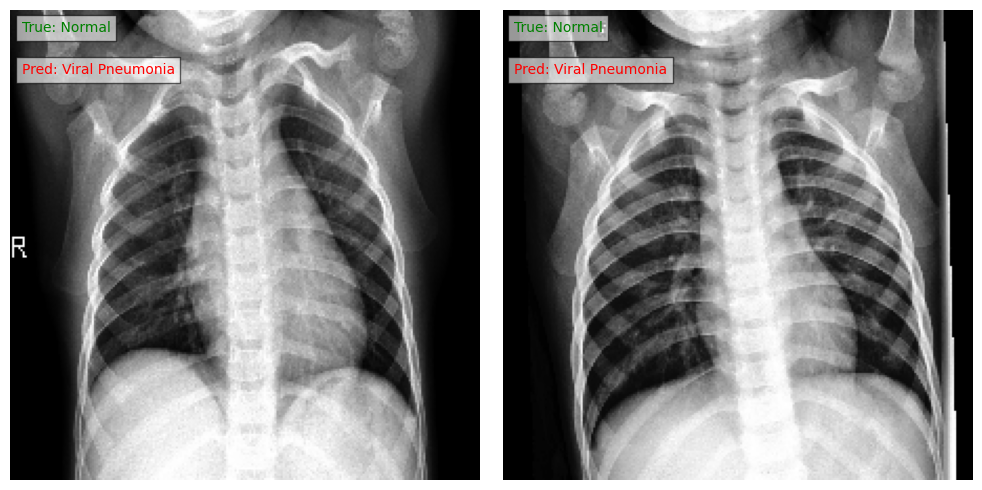

In [87]:

class_map = {0: 'Normal', 1: 'Viral Pneumonia', 2: 'Covid'}

plt.figure(figsize=(10, 5))
for i, index in enumerate(wrong_pred):
    plt.subplot(1, len(wrong_pred), i + 1)

    # reverting scalling (done in preprocessing stage)
    plt.imshow((images[index]*255).astype('uint8'))

    plt.text(5, 10, f"True: {class_map[int(true_labels[index])]}",
             color='green', bbox=dict(facecolor='white', alpha=0.6))
    plt.text(5, 30, f"Pred: {class_map[y_pred[index]]}",
             color='red', bbox=dict(facecolor='white', alpha=0.6))

    plt.axis('off')
plt.tight_layout()
plt.show()